In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load customer and transaction data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset
customers.head(), transactions.head()

(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  )

In [3]:
# Merge customers and transactions data
data = pd.merge(customers, transactions, on='CustomerID', how='inner')

# Feature Engineering: Create a 'Total Spend' column
data['Total_Spend'] = data['Quantity'] * data['Price']

# Aggregate data by customer
customer_profile = data.groupby('CustomerID').agg(
    Total_Spend=('Total_Spend', 'sum'),
    Avg_Spend_Per_Product=('Total_Spend', 'mean'),
    Unique_Products=('ProductID', 'nunique')
).reset_index()

# Display the aggregated customer profile
customer_profile.head()

,CustomerID,Total_Spend,Avg_Spend_Per_Product,Unique_Products
0,C0001,3354.52,670.904,5
1,C0002,1862.74,465.685,4
2,C0003,2725.38,681.345,4
3,C0004,5354.88,669.360,8
4,C0005,2034.24,678.080,3


In [4]:
# Standardize features to ensure equal importance during clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[['Total_Spend', 'Avg_Spend_Per_Product', 'Unique_Products']])

# Create a DataFrame for scaled features
scaled_df = pd.DataFrame(scaled_features, columns=['Total_Spend', 'Avg_Spend_Per_Product', 'Unique_Products'])
scaled_df.head()


,Total_Spend,Avg_Spend_Per_Product,Unique_Products
0,-0.061701,-0.070263,0.050047
1,-0.877744,-0.934933,-0.424204
2,-0.405857,-0.026271,-0.424204
3,1.032547,-0.076769,1.472798
4,-0.783929,-0.040028,-0.898455


D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avo

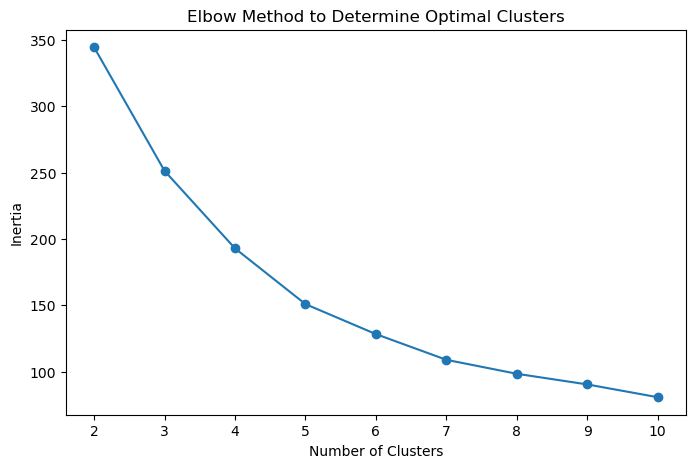

In [5]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [6]:
# Based on the Elbow Method, select the optimal number of clusters (e.g., 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_df)

# Display the first few rows with cluster assignments
customer_profile.head()


D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,CustomerID,Total_Spend,Avg_Spend_Per_Product,Unique_Products,Cluster
0,C0001,3354.52,670.904,5,1
1,C0002,1862.74,465.685,4,0
2,C0003,2725.38,681.345,4,1
3,C0004,5354.88,669.360,8,2
4,C0005,2034.24,678.080,3,0


In [7]:
# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_df, customer_profile['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.907195980147308


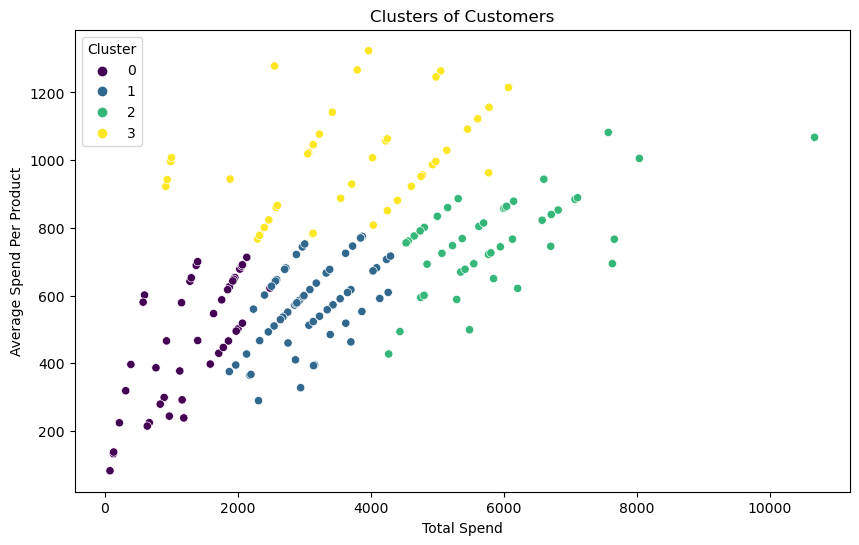

In [8]:
# Visualize clusters using a pair plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_profile['Total_Spend'],
    y=customer_profile['Avg_Spend_Per_Product'],
    hue=customer_profile['Cluster'],
    palette='viridis'
)
plt.title('Clusters of Customers')
plt.xlabel('Total Spend')
plt.ylabel('Average Spend Per Product')
plt.show()


In [9]:
# Save the cluster results to a CSV file
customer_profile[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)

# Display the cluster results
customer_profile[['CustomerID', 'Cluster']].head()


,CustomerID,Cluster
0,C0001,1
1,C0002,0
2,C0003,1
3,C0004,2
4,C0005,0
